In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
INIT_LR = 0.001
EPOCHS = 25
BS = 32

In [3]:
DIRECTORY = r"C:\Users\ANIKET THAKUR\Desktop\Dataset"
CATEGORIES = ["with_mask", "without_mask"]

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
print('task completed')

[INFO] loading images...


C:\Anaconda\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


task completed


In [4]:
dataset=pd.DataFrame(data={'image':data,'label':labels})
dataset.groupby(['label']).count()


,image
label,
with_mask,1925
without_mask,1932


In [5]:
le = LabelEncoder() 
  
labels=le.fit_transform(labels) 
labels = to_categorical(labels)

In [6]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

C:\Anaconda\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


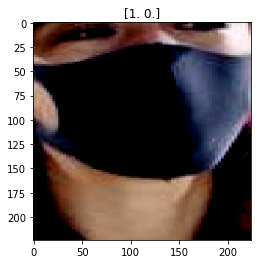

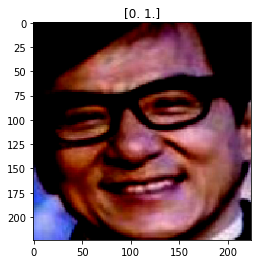

In [7]:
i=1000
j=3000
plt.figure(1)
plt.title(labels[i])
plt.imshow(data[i])

plt.figure(2)
plt.title(labels[j])
plt.imshow(data[j])




In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=32)

In [9]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.30,
                         width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.15,horizontal_flip=True,
                         vertical_flip=True,fill_mode="nearest")

In [10]:
aug

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,alpha=1.0,
                        input_tensor=Input(shape=(224, 224, 3)))

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7),data_format=None,
                             padding='valid')(headModel)
#Flatten the output of our base model to 1 dimension
headModel = Flatten(name="flatten")(headModel)
#Add a fully connected layer with 128 hidden units and ReLU activation
headModel = Dense(128, activation="relu")(headModel)
#Add dropout rate of 0.5 
headModel = Dropout(0.5)(headModel)
#Add a final softmax layer for classification
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("finished compiling")

[INFO] compiling model...
finished compiling


C:\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
              steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),
              validation_steps=len(testX) // BS,
              epochs=EPOCHS)

[INFO] training head...
Epoch 1/25
96/96 [==============================] - 169s 2s/step - loss: 0.2104 - accuracy: 0.9250 - val_loss: 0.0506 - val_accuracy: 0.9858
Epoch 2/25
96/96 [==============================] - 133s 1s/step - loss: 0.1091 - accuracy: 0.9587 - val_loss: 0.0443 - val_accuracy: 0.9845
Epoch 3/25
96/96 [==============================] - 129s 1s/step - loss: 0.0994 - accuracy: 0.9653 - val_loss: 0.0382 - val_accuracy: 0.9883
Epoch 4/25
96/96 [==============================] - 129s 1s/step - loss: 0.0819 - accuracy: 0.9699 - val_loss: 0.0382 - val_accuracy: 0.9858
Epoch 5/25
96/96 [==============================] - 133s 1s/step - loss: 0.0910 - accuracy: 0.9715 - val_loss: 0.0313 - val_accuracy: 0.9883
Epoch 6/25
96/96 [==============================] - 129s 1s/step - loss: 0.0864 - accuracy: 0.9669 - val_loss: 0.0302 - val_accuracy: 0.9909
Epoch 7/25
96/96 [==============================] - 130s 1s/step - loss: 0.0831 - accuracy: 0.9686 - val_loss: 0.0370 - val_accura

In [14]:
print("[INFO] evaluating network...")
prediction = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [17]:
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=le.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.98      0.99       385
without_mask       0.98      0.99      0.99       387

    accuracy                           0.99       772
   macro avg       0.99      0.99      0.99       772
weighted avg       0.99      0.99      0.99       772



In [18]:
print("saving mask detector model...")
model.save("mask_detector_final.model", save_format="h5")

saving mask detector model...


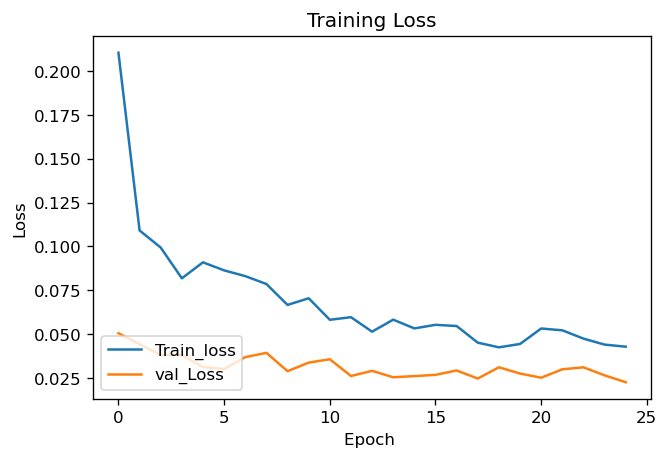

In [19]:
N = EPOCHS
plt.figure(dpi=120)
plt.plot(range(0, N), H.history["loss"], label="Train_loss")
plt.plot(range(0,N),H.history["val_loss"], label="val_Loss")
plt.title("Training Loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()




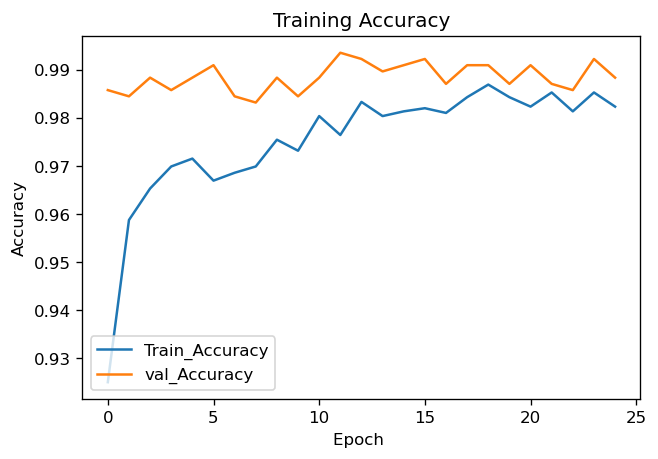

In [20]:
N = EPOCHS
plt.figure(dpi=120)
plt.plot(range(0, N), H.history["accuracy"], label="Train_Accuracy")
plt.plot(range(0,N),H.history["val_accuracy"], label="val_Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

In [14]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

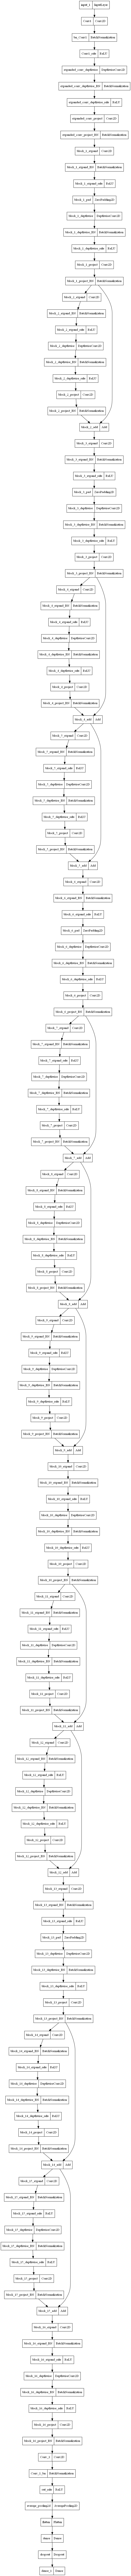

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_architecture.png')